# PA minería texto Inteligencia Negocio

In [ ]:
import numpy as np
import pandas as pd
df0 = pd.read_csv('ComentariosPositivos.txt', sep='*', header=0, names=["comments"])
df1 = pd.read_csv('ComentariosNeutros.txt', sep='*', header=0, names=["comments"])
df2 = pd.read_csv('ComentariosNegativos.txt', sep='*', header=0, names=["comments"])
df0["score"] = 10
df1["score"] = 5
df2["score"] = 0
df = pd.concat([df0,df1,df2],ignore_index=True)

: 

In [ ]:
df

### Procedimientos de tratamiento de texto y ejemplos de uso

In [ ]:
# ! pip install spacy
# ! python -m spacy download es_core_news_sm

In [ ]:
import spacy

In [ ]:
#
# Limpieza de frases
#

import spacy
from spacy.lang.es.examples import sentences 
nlp = spacy.load("es_core_news_sm")

from spacy.lang.es.stop_words import STOP_WORDS

def limpia_feedback(text):
    my_doc = nlp(text)
    token_list = []
    for token in my_doc:
        token_list.append(token.text)
    filtered_sentence =[] 
    for word in token_list:
        lexeme = nlp.vocab[word]
        if not lexeme.is_stop and lexeme.is_alpha:
            filtered_sentence.append(word.lower()) 
    return filtered_sentence



In [ ]:
#
# Ejemplo de limpieza
#
text = "Con cien cañones por Banda, viento en popa a toda vela"
print(limpia_feedback(text))   

In [ ]:
df.loc[0,'comments']

In [ ]:
print(limpia_feedback(df.loc[0,'comments']))

In [ ]:
#
# Palabras más frecuentes
#
from collections import Counter
import matplotlib.pyplot as plt

palabrasfrecuentes = []
todo_texto = []
for i,t in enumerate(df.loc[:,"comments"].values):
    nuevo = limpia_feedback(t)
    todo_texto += nuevo
topd = Counter(todo_texto)
topd = topd.most_common(20)
palabrasfrecuentes.append([p[0] for p in topd])

plt.bar(range(len(topd)), [val[1] for val in topd], align='center')
plt.xticks(range(len(topd)), [val[0] for val in topd])
plt.xticks(rotation=70)
plt.title('Palabras más frecuentes')
plt.show()


#### Distancias entre embeddings

In [ ]:
# ! pip install unidecode
# ! pip install scikit-learn
# ! pip install nltk

In [ ]:
#
# Embeddings de bolsa de palabras (TFIDF)
#


import re
import string
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer

# Limpieza con NLTK

# Eliminación de acentos, signos de puntuación, marcas, etc.
def ascii_only(str_):
	return unidecode(str_).encode("ascii", "ignore").decode()

def remove_nonwords(str_):
	return re.sub(r"[^A-Za-z0-9 ]\w+[^A-Za-z0-9]*", ' ', str_)

def remove_brandwords(str_):
	p = '''#?(iphone|ipad|sxsw|hcsm|google|apple|cisco|austin|
	atari|intel|mac|pc|blackberry|android|linux|ubuntu)[a-z0-9]*'''
	return re.sub(p, ' ', str_)

def remove_punctuations(str_, punctuations):
	table_ = str.maketrans('', '', punctuations)
	return str_.translate(table_)

def lemmatize(str_, sw):
	wnl = WordNetLemmatizer()
	return ' '.join([wnl.lemmatize(w) for w in str_.split() if w not in sw])

def preprocesa(df):
	df['tokenized_text']= df['text'].str.lower().apply(ascii_only)
	df['tokenized_text']= df['tokenized_text'].apply(remove_nonwords)
	df['tokenized_text']= df['tokenized_text'].apply(remove_brandwords)
	df['tokenized_text']= df['tokenized_text'].apply(remove_punctuations,args=(punctuations,))
	df['tokenized_text']= df['tokenized_text'].apply(lemmatize,args=(sw,))

punctuations = string.punctuation
punctuations = punctuations + string.digits

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

sw = stopwords.words('spanish')

def preprocesa(df):
	df['tokenized_text']= df['comments'].str.lower().apply(ascii_only)
	df['tokenized_text']= df['tokenized_text'].apply(remove_nonwords)
	df['tokenized_text']= df['tokenized_text'].apply(remove_brandwords)
	df['tokenized_text']= df['tokenized_text'].apply(remove_punctuations,args=(punctuations,))
	df['tokenized_text']= df['tokenized_text'].apply(lemmatize,args=(sw,))



In [ ]:
preprocesa(df)

In [ ]:
df

In [ ]:
#
# Palabras más frecuentes
#
from collections import Counter
import matplotlib.pyplot as plt

palabrasfrecuentes = []
todo_texto = []
for i,t in enumerate(df.loc[:,"comments"].values):
    nuevo = df.loc[i,"tokenized_text"].split(" ")
    todo_texto += nuevo
topd = Counter(todo_texto)
topd = topd.most_common(20)
palabrasfrecuentes.append([p[0] for p in topd])

plt.bar(range(len(topd)), [val[1] for val in topd], align='center')
plt.xticks(range(len(topd)), [val[0] for val in topd])
plt.xticks(rotation=70)
plt.title('Palabras más frecuentes')
plt.show()

### Aplicación de los procedimientos anteriores a los datos de feedback

In [ ]:
#
# Análisis cluster de los embeddings
#
from sklearn.cluster import AffinityPropagation

def generate_clusters(pos):
    clusterer = AffinityPropagation()
    clusterer.fit(pos)
    return clusterer.labels_


In [ ]:
# ! pip install umap_learn

In [ ]:
def extract_labels(textoscluster,centroide,pos):
    d = abs(pos-centroide)
    d = np.sum(d,axis=1)
    p = np.argmin(d)
    return textoscluster[p]

In [ ]:
#
# Proyecciones MDS, t-SNE y UMAP comparadas
#


import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
import matplotlib.cm as cm
import umap


def plot_MDS(similarity, labels, titulo, df):

    MINCLUSTER = 5
    
    colormap = cm.viridis 

    max_label = max(labels)+1
    clabel = [10*i/max_label for i in labels]
    colors = colormap(clabel)
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=10)

    f, ax = plt.subplots(1, 3, figsize=(18, 6))

    # MDS
    mds = MDS(n_components=2,dissimilarity="precomputed")
    pos = mds.fit(1-similarity).embedding_

    cluster = generate_clusters(pos)
    mycl = np.unique(cluster)
    print(mycl)

    sc = ax[0].scatter(pos[:,0], pos[:,1], alpha=0.25,  c=colors, edgecolors='black')
    ax[0].set_xlim((min(pos[:,0]),max(pos[:,0])))
    ax[0].set_ylim((min(pos[:,1]),max(pos[:,1])))
    for cl in mycl:
        if len(pos[cluster==cl])<MINCLUSTER:
            continue
        centroide = np.mean(pos[cluster==cl],axis=0)
        textoscluster = df.loc[:,"comments"].values[cluster==cl]
        exl = extract_labels(textoscluster,centroide,pos[cluster==cl])
        txt = ax[0].text(centroide[0],centroide[1],exl,fontsize=6,  ha='center', va='center', wrap=True)
        txt._get_wrap_line_width = lambda : 200

    ax[0].set_title('MDS '+titulo)
    f.colorbar(sm,ax=ax[0])

    # TSNE
    tsne = TSNE(metric="precomputed",init="random")
    pos = tsne.fit_transform(1-similarity)

    cluster = generate_clusters(pos)
    mycl = np.unique(cluster)
    print(mycl)

    sc = ax[1].scatter(pos[:,0], pos[:,1], alpha=0.25,  c=colors, edgecolors='black')
    ax[1].set_xlim((min(pos[:,0]),max(pos[:,0])))
    ax[1].set_ylim((min(pos[:,1]),max(pos[:,1])))
    for cl in mycl:
        if len(pos[cluster==cl])<MINCLUSTER:
            continue
        centroide = np.mean(pos[cluster==cl],axis=0)
        textoscluster = df.loc[:,"comments"].values[cluster==cl]
        exl = extract_labels(textoscluster,centroide,pos[cluster==cl])
        txt = ax[1].text(centroide[0],centroide[1],exl,fontsize=6,  ha='center', va='center', wrap=True)
        txt._get_wrap_line_width = lambda : 200
    ax[1].set_title('TSNE '+titulo)
    f.colorbar(sm,ax=ax[1])
    
    # UMAP
    uma = umap.UMAP(metric="precomputed",init="random")
    pos = uma.fit_transform(1-similarity)

    cluster = generate_clusters(pos)
    mycl = np.unique(cluster)
    print(mycl)

    sc = ax[2].scatter(pos[:,0], pos[:,1], alpha=0.25,  c=colors, edgecolors='black')
    ax[2].set_xlim((min(pos[:,0]),max(pos[:,0])))
    ax[2].set_ylim((min(pos[:,1]),max(pos[:,1])))
    for cl in mycl:
        if len(pos[cluster==cl])<MINCLUSTER:
            continue
        centroide = np.mean(pos[cluster==cl],axis=0)
        textoscluster = df.loc[:,"comments"].values[cluster==cl]
        exl = extract_labels(textoscluster,centroide,pos[cluster==cl])
        txt = ax[2].text(centroide[0],centroide[1],exl,fontsize=6,  ha='center', va='center', wrap=True)
        txt._get_wrap_line_width = lambda : 200
        print("Cluster",cl)
        print("textos:",textoscluster)
        print("Etiqueta:",exl)
    ax[2].set_title('UMAP '+titulo)
    f.colorbar(sm,ax=ax[2])

    plt.show()


### Similaridad por contenido y proyecciones de embeddings TFIDF

In [ ]:
tfvec = TfidfVectorizer(ngram_range = (1, 2), min_df = 2)
tf_vectors = tfvec.fit_transform(df['tokenized_text'].to_numpy())

texts = []
scores = []
embeddings = []
similarities = []

# Textos
texts.append(list(df.loc[:,"comments"].values))
# Scores
score = np.array([int(v) for v in df.loc[:,"score"].values])
scores.append(score)
# Embeddings
embedding = []
for i,txt in enumerate(df.loc[:,"comments"].values):
    embedding += [tf_vectors[i].toarray()]
embeddings.append(embedding)
# Matrices de similaridad
ndocs = len(df.loc[:,"comments"].values)
similarity = np.zeros((ndocs,ndocs))
for i in range(ndocs):
    for j in range(i,ndocs):
        similarity[i,j] = 1-np.mean((embedding[i] - embedding[j])**2) 
        similarity[j,i] = similarity[i,j]
similarities.append(similarity)        


In [ ]:
diccionario = tfvec.get_feature_names_out()

In [ ]:
diccionario[:200]

In [ ]:
ncomment = 10

In [ ]:
print(df.loc[ncomment,"comments"])

In [ ]:
embeddings[0][ncomment][0]

In [ ]:
for i,c in enumerate(embeddings[0][ncomment][0]):
    if c!=0:
        print(i,c,diccionario[i])

In [ ]:
similarities

In [ ]:
plot_MDS(similarity, score, "TFIDF", df)

### Similaridad por contenido+score y proyecciones de embeddings contextuales

In [ ]:
# Añadimos el score a la similaridad para hacer el clustering

def plot_MDS_score(similarity, labels, titulo, df):

    MINCLUSTER = 5
    
    colormap = cm.viridis 

    max_label = max(labels)+1
    clabel = [10*i/max_label for i in labels]
    colors = colormap(clabel)
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=10)

    f, ax = plt.subplots(1, 1, figsize=(18, 6))

    
    # UMAP
    uma = umap.UMAP(metric="precomputed")
    pos = uma.fit_transform(1-similarity)

    cluster = generate_clusters(pos)
    mycl = np.unique(cluster)
    print(mycl)

    sc = ax.scatter(pos[:,0], pos[:,1], alpha=0.25,  c=colors, edgecolors='black')
    ax.set_xlim((min(pos[:,0]),max(pos[:,0])))
    ax.set_ylim((min(pos[:,1]),max(pos[:,1])))
    for cl in mycl:
        if len(pos[cluster==cl])<MINCLUSTER:
            continue
        centroide = np.mean(pos[cluster==cl],axis=0)
        textoscluster = df.loc[:,"comments"].values[cluster==cl]
        exl = extract_labels(textoscluster,centroide,pos[cluster==cl])
        if len(exl)>100:
            exl = exl[:100]
        txt = ax.text(centroide[0],centroide[1],exl,fontsize=6,  ha='center', va='center', wrap=True)
        txt._get_wrap_line_width = lambda : 200
        # print("Cluster",cl)
        # print("textos:",textoscluster)
        # print("Etiqueta:",exl)
    ax.set_title('UMAP '+titulo)
    f.colorbar(sm,ax=ax)

    

    plt.show()

/Users/lucianosanchez/dataenv3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/lucianosanchez/dataenv3.12/lib/python3.12/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


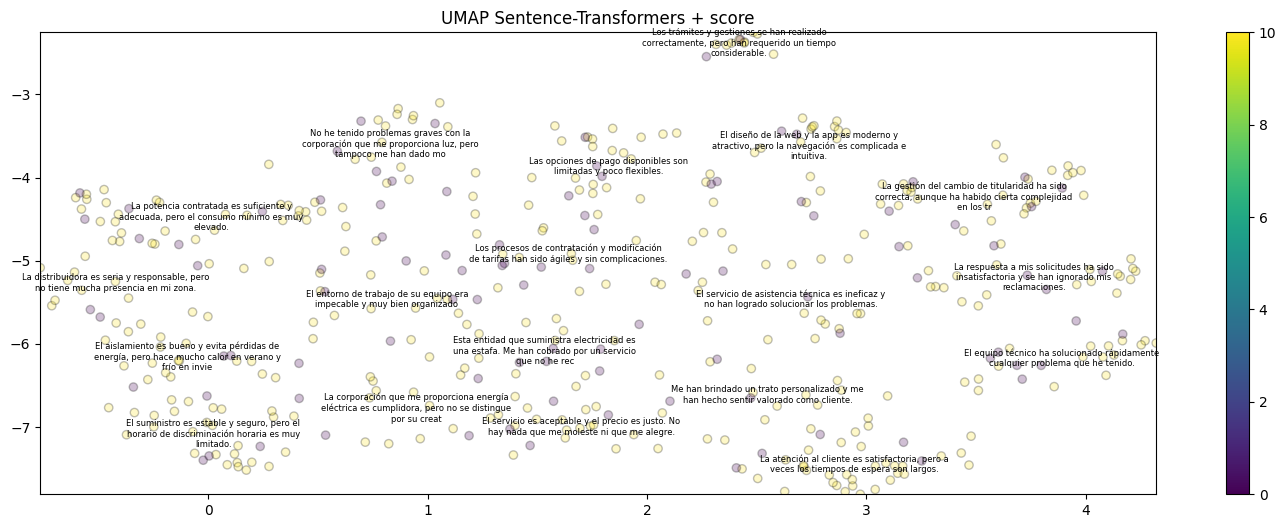

In [ ]:
# Textos
texts.append(list(df.loc[:,"comments"].values))

# Scores
score = np.array([int(v) for v in df.loc[:,"score"].values])

# Embeddings
embedding = []
for i,txt in enumerate(tf_vectors): # df.loc[:,"comments"].values:
    embedding += [tf_vectors[i].toarray()]

# Matrices de similaridad
ndocs = len(df.loc[:,"comments"].values)
similarity = np.zeros((ndocs,ndocs))
for i in range(ndocs):
    for j in range(i,ndocs):
        # Cambiando este valor se modifica el agrupamiento por sentimiento (cuanto más alto, menos importancia se le da al score)
        lmbd = 0.9
        # Tenemos en cuenta el parecido en el contenido y también el parecido en el sentimiento (solo con el feedback)
        similarity[i,j] = 1-(lmbd*np.mean((embedding[i] - embedding[j])**2) + (1-lmbd)*(1-abs(score[i]-score[j])/10.0))
        similarity[j,i] = similarity[i,j]
similarities.append(similarity)        
plot_MDS_score(similarity, score, "Sentence-Transformers + score", df)

## Solución final con gráfico interactivo

In [40]:
import math
class AnnoteFinder(object):
    """callback for matplotlib to display an annotation when points are
    clicked on.  The point which is closest to the click and within
    xtol and ytol is identified.
    
    Register this function like this:
    
    scatter(xdata, ydata)
    af = AnnoteFinder(xdata, ydata, annotes)
    connect('button_press_event', af)
    """

    def __init__(self, xdata, ydata, annotes, ax=None, xtol=None, ytol=None):
        self.data = list(zip(xdata, ydata, annotes))
        if xtol is None:
            xtol = ((max(xdata) - min(xdata))/float(len(xdata)))/2
        if ytol is None:
            ytol = ((max(ydata) - min(ydata))/float(len(ydata)))/2
        self.xtol = xtol
        self.ytol = ytol
        if ax is None:
            self.ax = plt.gca()
        else:
            self.ax = ax
        self.drawnAnnotations = {}
        self.links = []

    def distance(self, x1, x2, y1, y2):
        """
        return the distance between two points
        """
        return(math.sqrt((x1 - x2)**2 + (y1 - y2)**2))

    def __call__(self, event):

        if event.inaxes:

            clickX = event.xdata
            clickY = event.ydata
            if (self.ax is None) or (self.ax is event.inaxes):
                annotes = []
                # print(event.xdata, event.ydata)
                for x, y, a in self.data:
                    # print(x, y, a)
                    if ((clickX-self.xtol < x < clickX+self.xtol) and
                            (clickY-self.ytol < y < clickY+self.ytol)):
                        annotes.append(
                            (self.distance(x, clickX, y, clickY), x, y, a))
                if annotes:
                    annotes.sort()
                    distance, x, y, annote = annotes[0]
                    self.drawAnnote(event.inaxes, x, y, annote)
                    for l in self.links:
                        l.drawSpecificAnnote(annote)

    def drawAnnote(self, ax, x, y, annote):
        """
        Draw the annotation on the plot
        """
        if (x, y) in self.drawnAnnotations:
            markers = self.drawnAnnotations[(x, y)]
            for m in markers:
                m.set_visible(not m.get_visible())
            self.ax.figure.canvas.draw_idle()
        else:
            t = ax.text(x, y, " - %s" % (annote),)
            m = ax.scatter([x], [y], marker='d', c='r', zorder=100)
            self.drawnAnnotations[(x, y)] = (t, m)
            self.ax.figure.canvas.draw_idle()

    def drawSpecificAnnote(self, annote):
        annotesToDraw = [(x, y, a) for x, y, a in self.data if a == annote]
        for x, y, a in annotesToDraw:
            self.drawAnnote(self.ax, x, y, a)

In [41]:

def plot_MDS_score_anotado(similarity, labels, titulo, df):

    MINCLUSTER = 5
    
    colormap = cm.viridis 

    max_label = max(labels)+1
    clabel = [10*i/max_label for i in labels]
    colors = colormap(clabel)
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=10)

    f, ax = plt.subplots(1, 1, figsize=(18, 6))

    
    # UMAP
    uma = umap.UMAP(metric="precomputed")
    pos = uma.fit_transform(1-similarity)

    cluster = generate_clusters(pos)
    mycl = np.unique(cluster)
    print(mycl)

    sc = ax.scatter(pos[:,0], pos[:,1], alpha=0.25,  c=colors, edgecolors='black')
    ax.set_xlim((min(pos[:,0]),max(pos[:,0])))
    ax.set_ylim((min(pos[:,1]),max(pos[:,1])))
    for cl in mycl:
        if len(pos[cluster==cl])<MINCLUSTER:
            continue
        centroide = np.mean(pos[cluster==cl],axis=0)
        textoscluster = df.loc[:,"comments"].values[cluster==cl]
        # exl = extract_labels_dborrelli(textoscluster)
        exl = extract_labels(textoscluster,centroide,pos[cluster==cl])
        if len(exl)>100:
            exl = exl[:100]
        txt = ax.text(centroide[0],centroide[1],exl,fontsize=6,  ha='center', va='center', wrap=True)
        txt._get_wrap_line_width = lambda : 200
        # print("Cluster",cl)
        # print("textos:",textoscluster)
        # print("Etiqueta:",exl)
    ax.set_title('UMAP '+titulo)
    f.colorbar(sm,ax=ax)

    annotes = df["comments"].values
    af =  AnnoteFinder(pos[:,0],pos[:,1], annotes, ax=ax)
    f.canvas.mpl_connect('button_press_event', af)
    

    plt.show()

In [42]:
# ! pip install ipympl

/Users/lucianosanchez/dataenv3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/lucianosanchez/dataenv3.12/lib/python3.12/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


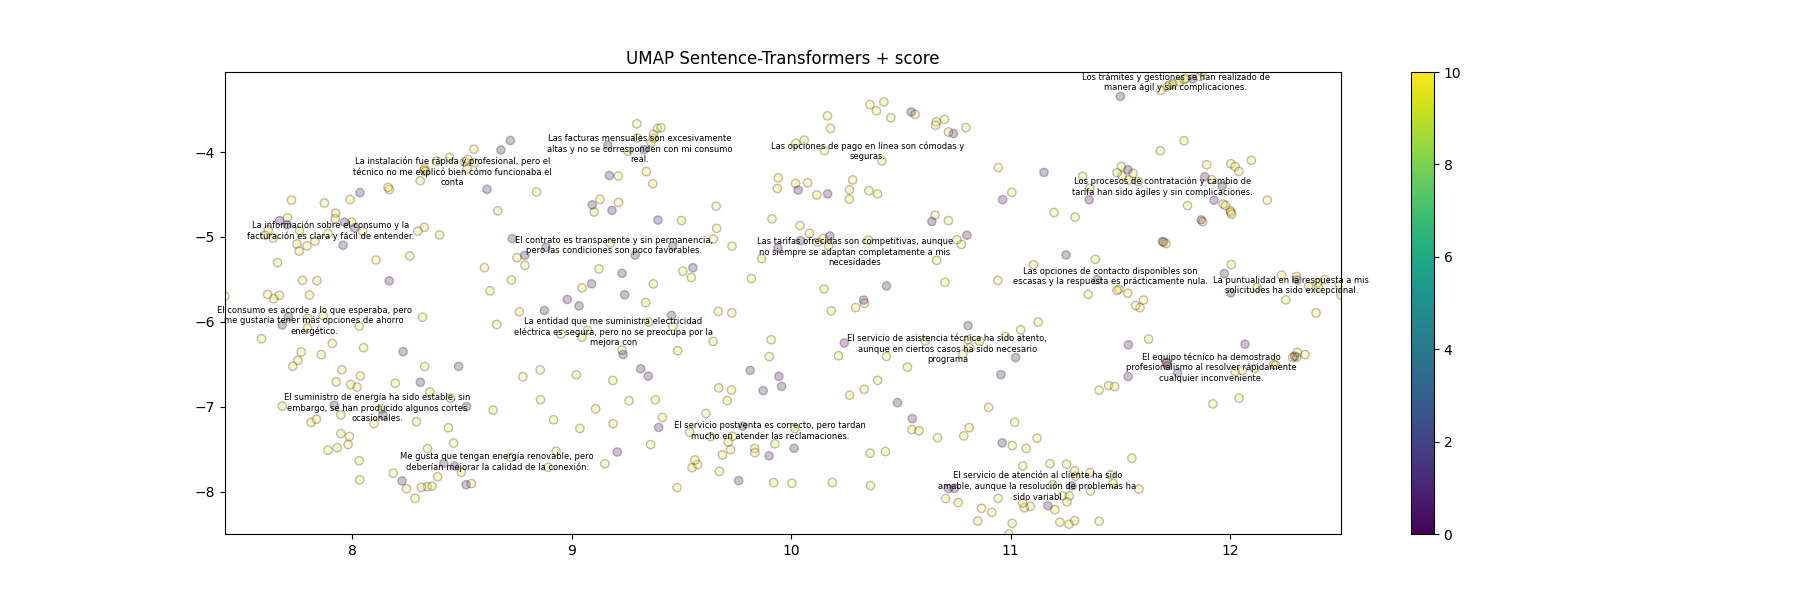

In [43]:
%matplotlib widget
plot_MDS_score_anotado(similarity, score, "Sentence-Transformers + score", df)